In [2]:
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Activation, Reshape, Lambda, LeakyReLU
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from util_func import resize_, load_training_data_, tf_format

%matplotlib inline

### Define architecture of a convolutional neural networks (CNN)
We emply deep learning network with an encoder-decoder type of topology. The encoder part consists of three blocks of convolutional layers, activated by a rectified linear unit function, for feature extraction and max-pooling layers in between them to account for a translational invariance. The number of filters (“neurons”) per convolutional layer is doubled for each next block. The decoder part contains the same blocks of convolutional layers but in the reversed order and upsampling with bilinear interpolation in between them, which allows to map the extracted features back to the original size of input data. To prevent our model from overfitting, a dropout layer was placed after each layer.

In [2]:
nb_classes = 3
target_size = (256, 256)

visible = Input(shape=(target_size[0], target_size[1], 1))
x = Dropout(0.2)(visible)

x = Convolution2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(128, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(256, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Lambda(resize_, arguments={'ref_':(64, 64)})(x)

x = Convolution2D(128, (3, 3), activation='relu', padding='same')(x)
x = Convolution2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Lambda(resize_, arguments={'ref_':(128, 128)})(x)

x = Convolution2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = Lambda(resize_, arguments={'ref_':(256, 256)})(x)

x = Convolution2D(nb_classes, (3, 3), activation = 'linear', padding='same')(x)
decoded = Activation('softmax')(x)

model = Model(visible, decoded)


### Load training data
Here the training data is already in tf/keras format so no need to worry.

In [14]:
X, y = load_training_data_(r'../Data/Graphene-training-set-12a.hdf5')
print(X.shape, y.shape)

(3000, 256, 256, 1) (3000, 256, 256, 3)


Split into training and test datasets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Visualizing training images dataset and corresponding labels/ground truth

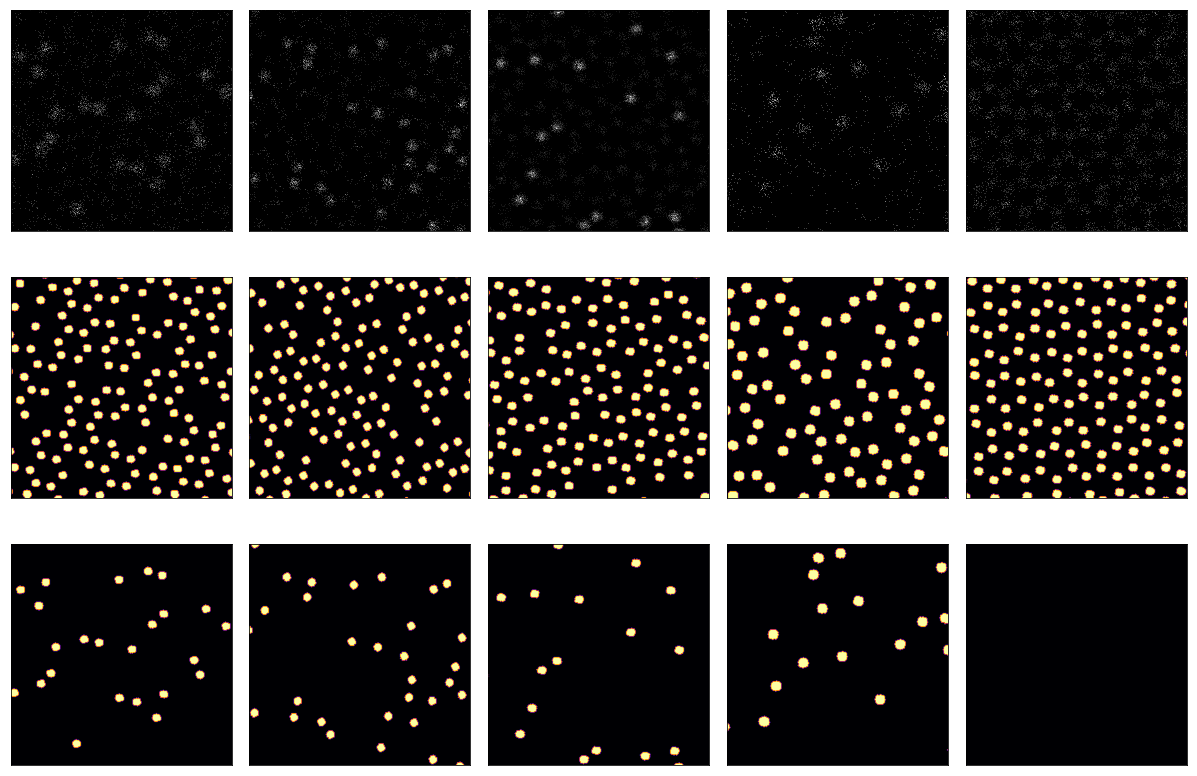

In [5]:
n = 6
plt.figure(figsize=(20, 15))

for i in range(1, n):
    ax = plt.subplot(4, n, i)
    plt.imshow(X_train[i].reshape(target_size[0], target_size[1]), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
       
    ax = plt.subplot(4, n, i + n)
    plt.imshow(y_train[i, :,:,0], cmap = 'inferno', Interpolation = 'Gaussian')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(4, n, i + 2*n)
    plt.imshow(y_train[i, :,:,1], cmap = 'inferno', Interpolation = 'Gaussian')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()

plt.show() 

## Compile and train a model
Finally we can train our model using the simulated images as a training data.

In [6]:
input_img = Input(shape=(target_size[0], target_size[1], 1)) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
callback_tb = TensorBoard(log_dir='/tmp/AtomGen_prec_', histogram_freq=0,
                          write_graph=True, write_images=False)

model.fit(X_train, y_train, epochs=30, batch_size=32, 
          validation_data=(X_test, y_test), shuffle=True, verbose = 1)

Train on 2250 samples, validate on 750 samples
Epoch 1/30
2250/2250 [==============================] - 127s 56ms/step - loss: 0.6365 - acc: 0.8154 - val_loss: 0.5290 - val_acc: 0.8260
Epoch 2/30
2250/2250 [==============================] - 115s 51ms/step - loss: 0.5301 - acc: 0.8256 - val_loss: 0.5259 - val_acc: 0.8260
Epoch 3/30
2250/2250 [==============================] - 116s 51ms/step - loss: 0.3619 - acc: 0.8563 - val_loss: 0.1964 - val_acc: 0.9204
Epoch 4/30
2250/2250 [==============================] - 116s 51ms/step - loss: 0.1632 - acc: 0.9322 - val_loss: 0.1343 - val_acc: 0.9449
Epoch 5/30
2250/2250 [==============================] - 116s 51ms/step - loss: 0.1376 - acc: 0.9414 - val_loss: 0.1204 - val_acc: 0.9489
Epoch 6/30
2250/2250 [==============================] - 116s 51ms/step - loss: 0.1290 - acc: 0.9445 - val_loss: 0.1143 - val_acc: 0.9516
Epoch 7/30
2250/2250 [==============================] - 116s 51ms/step - loss: 0.1242 - acc: 0.9464 - val_loss: 0.1157 - val_acc: 0

We can plot the training history for train and validation losses.

Training history


Text(0,0.5,'Loss')

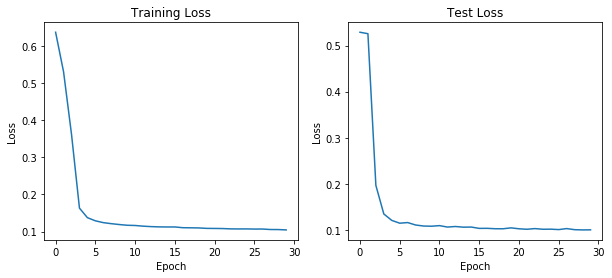

In [7]:
print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(model.history.history['loss'])
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
#ax1.set_yscale('log')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(model.history.history['val_loss'])
ax2.set_title('Test Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
#ax2.set_yscale('log')

It might be a good idea to save a model!

In [9]:
model.save("test-1.h5")
print('Saved model to disk.\n')

Saved model and weights to disk.



Now let's see if we can load the same model again.

In [10]:
model = load_model('test-1.h5')

We can view the model's summary.

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
__________

Let's see how well the model performed on the validation set.

In [12]:
X_test_d = model.predict(X_test)

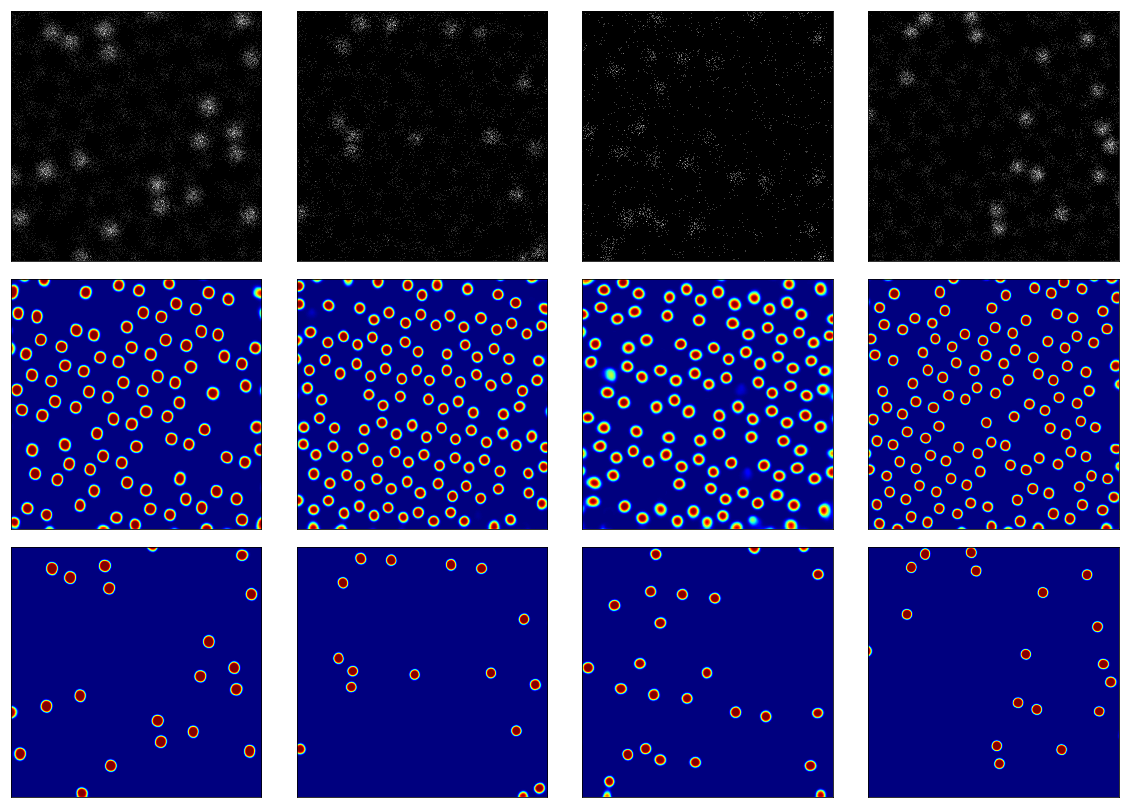

In [13]:
n = 5
plt.figure(figsize=(20, 15))

for i in range(1, n):
    ax = plt.subplot(4, n, i)
    plt.imshow(X_test[i].reshape(target_size[0], target_size[1]), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
          
    ax = plt.subplot(4, n, i + n)
    plt.imshow(X_test_d[i, :,:,0], cmap = 'jet', Interpolation = 'Gaussian')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
       
    ax = plt.subplot(4, n, i + 2*n)
    plt.imshow(X_test_d[i, :,:,1], cmap = 'jet', Interpolation = 'Gaussian')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()

plt.show() 